Because of the mention to change the multipliers in the question I assumed that the strategy would involve farming Yolo points to then be used in the gold rush game. The multiplier has now been brought down further to 5 (which did cause some confusion at first).

I ignore the lottery game which will of course minorly improve the EV.

I have had to make some other assumptions and in some cases leave values as variables as I am writing this as gold is being distributed and as such we cannot know how much there is to be distributed. Yolo games has been allocated 2.3m gold but how that is split over the seasons is not clear.

I'm going to leave the proportion of gold left and the number of earning days left as variables that can be set. Earning days are days when gold can be earned.

I was also not able to find good information on Yolo points distributed per game as a function of size. I played 3 games with different sizes and the allocation seemed to be 100 points per .01ETH used as .01 eth is the minimum (Making it 10_000 points/ETH). Then multipliers are applied to this which are a function of time. I tried to get answers in the discord but I think it's been left deliberately vague to deter farming.

The EV of this game should be easy to calculate as the game is a cong flip (Really a random walk). Our strategy is going to be to be as the first in to secure the highest multiplier (5x in reality but 20x for the sake of the question). There is a drawback to this strategy in that if we go first and are the only participant to enter the game then our EV is atrocious. We will have a parameter q of the proportion of the time that this happens. The rest of the time we will make the simplifying assumption that moon and doom both have an equal number bet. In theory this should work as if the game is unblanced it is +EV to back the less backed side. In the long run being on the underbet and overbet sides should cancel but it would be worth seeing if one side generally gets more volume and backing it (I would guess this to be moon as degens like being long). I would also bet the smallest increment which is .01ETH as larger amounts would make it less likely that the book will balance. We can also bet every minute so we have ample opportunities to farm.

The value of a point is the last actually difficult value to get we will do this from the leaderboard. Each round of gold rush costs 50_000 points to enter. We also know that there is some proportion x of the gold that Yolo still has to give out. We have to extrapolate until the end of the gold proving period. I will do this linearly as you generally lose money by playing so compounding ROI's don't make much sense to use. Then we can use a rough metric to get the value of points. The idea is that each point should be roughly equally valuable nad so the value of each point in gold is (total gold value) / (total number of points). This of course is precisely true as you need 50k points to have a chance at winning gold and some will never accumulate that much.

I have pulled the leaderboard below through the front end but it only contains the top 300 points scorers in practice you would want to model out the rest of the people trading to get a truer ROI. I have puled this information using selenium which interacts with the front end. If you want to use it you will need to provide the path to your local chrome driver.


In [1]:
# import libraries
from scrape import ScrapeLeaderboard
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

### Gold assumptions, editable

In [2]:
gold_value = 6
yolo_gold = int(2.3e6)
proportion_left = .1 ## This is really hard to estimate currently as all gold has been distributed

### Leaderboard assumptions, editable

In [3]:
season_start = dt.datetime(2024, 6, 12, tzinfo=dt.timezone.utc)
today = dt.datetime(2024, 6, 25, tzinfo=dt.timezone.utc)
gold_distributed = dt.datetime(2024, 6, 26, tzinfo=dt.timezone.utc)

### Scrape the leaderboard, pulling from csv is default

In [4]:
pull_leaderboard = False
chrome_driver = "/usr/lib/chromium-browser/chromedriver"
leaderboard_url = r'https://yologames.io/rewards/leaderboard'

In [5]:
if pull_leaderboard:
    scraper = ScrapeLeaderboard("/usr/lib/chromium-browser/chromedriver", r'https://yologames.io/rewards/leaderboard')
    df = scraper.scrape_to_df()
else:
    df = pd.read_csv('leaderboard.csv')

## Point calculations

In [6]:
total_gold_value = gold_value * yolo_gold * proportion_left

# Extrapolate the leaderboard to the end of the gold earning season
df["Total_Extrapolated"] = df["Total"] * (gold_distributed - season_start) / (today - season_start)

point_value = total_gold_value / df["Total_Extrapolated"].sum()

## Next the math for the game EV

As stated above the number of points seems to be 10_000 * ETH deposited to play. So wer get 10_000 / ETHPrice per dollar. Therefore the value I get from each game is:
$$ EV = \text{NumberOfUSD} \times (\left(\frac{10,000}{\text{ETHPrice}}\right) \times \text{Multiplier} + 500I) \times \text{PointValue}$$
The NumberOfUSD param is used as we want the value of the game in dollars we could get it in ETH by removing the ETHPrice divisor

There is a 500 points bonus for anyone whi enters moon or doom first as outlined in the docs https://docs.yologames.io/rewards/points. The I is an indicator function that is 1 when we are first to enter 


## Now we want the actual game EV excluding points prizes etc
One thing to notice is that when we are the only player to enter the game as mentioned above we cannot win and can only lose. This is because either:
- We lose and lose our x usd bet
- we win and just win back what we put in minus the fee which comes to be $( x \times (1 - f) - x) = -fx $ where f is the fee
Therefore our ev in this case is
$$ EV[x] = \left(\frac{1}{\text{2}}\right) ( -x ) + \left(\frac{1}{\text{2}}\right) (-xf)  = - \frac{x}{\text{2}}[1 + f] $$

Otherwise our EV is simpler at 
$$ EV[x] = \left(\frac{1}{\text{2}}\right) ( -x ) + \left(\frac{1}{\text{2}}\right) ( x \times (1 - 2f)) = \left(\frac{1}{\text{2}}\right) \times [ x- 2fx -x] = -fx $$

Notice we use 2f as the fee is on our payout and we assume that to be 2x.
Now assuming we are the only person in the game proportion t of the time we can calculate the total ev using
- NumberOfUSD can be replaced with x as it is just the dollars wagered
- ETHPrice = E
- Multiplier = M
- PointValue = P
  

$$ EV[x] = x \times (\frac{10,000}{E} \times M + 500I )\times P - ( t \times \frac{x}{\text{2}}[1 + f] + (1 - t) \times (fx)) + 500I = 
x[\frac{(10,000M+500I)P}{E})   - (f + \frac{t}{2} - \frac{ft}{2})]  + 500I $$

As x is a scalar constant we can do calculations below ignoring it and then scale up by multiplying

In [7]:
def expected_value(multiplier: int, point_value: float, eth_price: float, fee: float, proportion_alone: float, was_first: bool):
    return ((10_000 * multiplier + 500 * was_first) * point_value) / eth_price - (fee + (proportion_alone / 2) - ((fee * proportion_alone) / 2))

In [8]:
multiplier = 20
point_value = point_value ## see above
eth_price = 3_400
fee = 1 / 100
prortion_alone = .25
was_first = True

In [9]:
expected_value(multiplier, point_value, eth_price, fee, prortion_alone, was_first)

np.float64(0.20666585414724367)

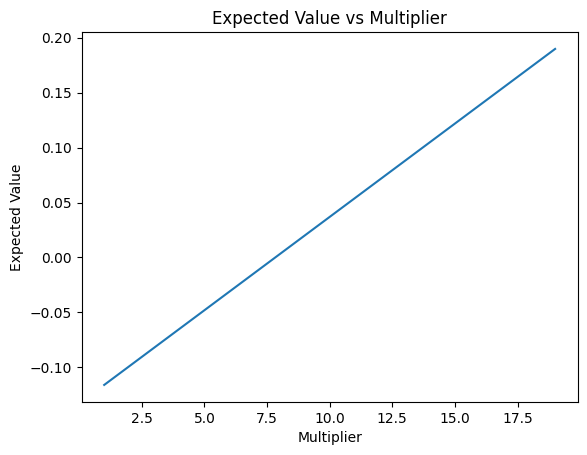

In [10]:
## Plot vs multipliers

multipliers = range(1, 20)
values = [expected_value(multiplier, point_value, eth_price, fee, prortion_alone, was_first) for multiplier in multipliers]

plt.plot(multipliers, values)
plt.xlabel("Multiplier")
plt.ylabel("Expected Value")
plt.title("Expected Value vs Multiplier")
plt.show()

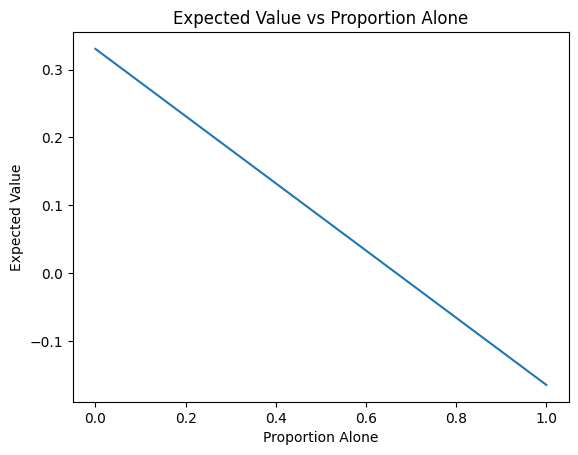

In [11]:
## Plot vs proportion alone

alone = np.linspace(0, 1, 100)
values = [expected_value(multiplier, point_value, eth_price, fee, proportion, was_first) for proportion in alone]

plt.plot(alone, values)
plt.xlabel("Proportion Alone")
plt.ylabel("Expected Value")
plt.title("Expected Value vs Proportion Alone")
plt.show()


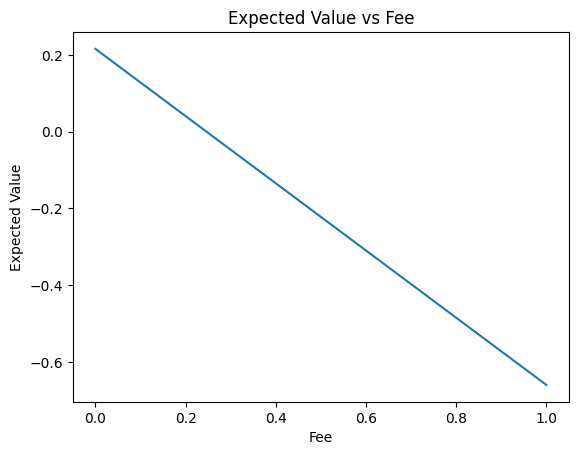

In [12]:
## Plot vs fee

fees = np.linspace(0, 1, 100)
values = [expected_value(multiplier, point_value, eth_price, fee, prortion_alone, was_first) for fee in fees]

plt.plot(fees, values)
plt.xlabel("Fee")
plt.ylabel("Expected Value")
plt.title("Expected Value vs Fee")
plt.show()

The roi can be seen by using the expected value function. I get around .2$ per spin which is very high so I know that ny numbers are wrong (although at the current multiplier of 5x it is still not profitable)

To relay this information to a programmer I would just tell them to.
- Find the game contract
- Find the timing mechanism that the game used to tell time, via the contact code (its in the round struct).
- Then sync transactions to this
- Each minute we should submit a transaction trying to be first as to secure the 500 point bonus and get the 20x bonus
  - If the chain is congested we should report this any maybe stop if we can't get in in time
- Call either the enterMoon or enterDoom on the MoonOrDoomNativeToken.sol contract at 0x693B37a9859Ce9465Fb2aAdeB03811a26A0c37C0. (This should maybe be randomized to avoid being gamed).
  - Before calling the contract you will need to query the epoch from the contract and submit the function call with that epoch + 1.
  - You will also need to pat .01ETH to the contract per call tom play the game
- Monitor the chain for any updates to the contract and stop the bot for safety
- Monitor the ETH balance in the wallet and ensure that it is not going down faster than expected